In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from collections import Counter
from sklearn.inspection import permutation_importance
import miceforest as mf
from sklearn.metrics import confusion_matrix, r2_score, root_mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegressionCV, LassoCV, LogisticRegression
import importlib
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='pred_lavSQ_MHC'
print(fileloc_data)
code_path='/'.join(os.getcwd().split('/')[0:4])+'/sklvq/'
sys.path.append(code_path)
from sklvq import GMLVQ, LGMLVQ
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,)
from sklearn.svm import SVC, SVR
from EDdataset_GGZ import colsTypeCast  
from HypOpt import lowest_cwacc

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/


/home/sreejita/anaconda3/envs/py_env1/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Classification

In [2]:
%load_ext autoreload
from GetDataReady import getDataNormalized

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling


## All classes

In [3]:
choice_dict={1.0: 'Core-DT, 5Cls', 1.1: 'Core-DT, only ED', 1.2: 'Core-DT, 3 ED and Others',
    2.0: 'Core-DT-EDEQ subscale, 5Cls', 2.1: 'Core-DT-EDEQ subscale, only ED', 2.2: 'Core-DT-EDEQ subscale, 3 ED and Others',
    3.0: 'Core, 5Cls', 3.1: 'Core, only ED', 3.2: 'Core, 3 ED and Others'}
save_dict={1.0: 'Core-DT-5Cls', 1.1: 'Core-DT-onlyED', 1.2: 'Core-DT-3ED-Others',
    2.0: 'Core-DT-EDEQ-5Cls', 2.1: 'Core-DT-EDEQ-only-ED', 2.2: 'Core-DT-EDEQ-3ED-Others',
    3.0: 'Core-5Cls', 3.1: 'Core-onlyED', 3.2: 'Core-3ED-Others'}
dataset_types={}
for key, val in choice_dict.items():
    dataset_types[key]=getDataNormalized(key)

1.0: For dataset with Core, DT, and 5 classes (Ndims=24):

1.1: For dataset with Core, DT and only ED classes:

1.2: For dataset with Core, DT and 3 ED classes and Others:

2.0: For dataset with Core, DT, EDEQ subscales and all 5 classes (Ndim=27):

2.1: For dataset with Core, DT, EDEQ subscales, and only ED classes:

2.2: For dataset with Core, DT, EDEQ subscales and 3 ED classes and Others:

3.0: For dataset with Core only, and all 5 classes (Ndim=16):

3.1: For dataset with Core only, and only ED classes:

3.2: For dataset with Core, and 3 ED classes and Others:



In [4]:
from sklearn.metrics import roc_auc_score
iters, nreps=5,10
fimp_all_exps, labs_all, prots_lvq_all, auc_all={},{},{},{}
train_conf_all_Exps, test_conf_all_Exps, classifiers_all_Exps={},{},{}
use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
savepicklpath='%s/pickles/'%(os.getcwd())
for keyData, valData in choice_dict.items():
    train_conf_all, test_conf_all, classifiers_all={},{},{}
    dataset_type=save_dict[keyData]#'Core_DT'#save_dict[choice]
    YTrain, YTest=dataset_types[keyData]['Ytrain'], dataset_types[keyData]['Ytest']  
    if keyData>=3:        
        zXTrain, zXTest=dataset_types[keyData]['zXtrain'], dataset_types[keyData]['zXtest']  
    else:
        zXTrain, zXTest=dataset_types[keyData]['mice_zXtrain'], dataset_types[keyData]['mice_zXtest']
    labs_all[keyData]=np.unique(YTrain)
    num_features, nclasses=zXTrain.shape[1], len(np.unique(YTrain))
    model_fname='%s_clf2.pkl'%dataset_type
    modelsClassify='%s%s'%(savepicklpath, model_fname)
    modelsClassify_permut='%s%s_%s.pkl'%(savepicklpath,dataset_type, 'FtrImp')
    modelsClassify_prots='%s%s_%s.pkl'%(savepicklpath,dataset_type, 'Prots')
    if os.path.exists(modelsClassify):
        pipeClassifiers_all = pickle.load(open(modelsClassify, "rb"))
        permut_model=pickle.load(open('%s'%modelsClassify_permut, "rb"))
        prots_model=pickle.load(open('%s'%modelsClassify_prots, "rb"))
        print('Loading final %s Classification models complete'%valData)          
        use_permutation_imp, nreps, prots_lvq, fimp_all=list(permut_model.keys()),10,{},{}
        clf_auc={}
        tr_cmap, te_cmap=np.zeros((iters, nclasses, nclasses)), np.zeros((iters, nclasses, nclasses))  
        tr_auc_roc, te_auc_roc=np.zeros((iters,nclasses+1)), np.zeros((iters, nclasses+1))        
        all_prots={}
        for keyClf, clf in pipeClassifiers_all.items():                        
            tr_cmap, te_cmap=np.zeros((iters,nclasses, nclasses)), np.zeros((iters, nclasses, nclasses))
            if keyClf in ['LGMLVQ1', 'LGMLVQ2', 'GNB', 'LogLASSO']:
                all_ftr_vars=np.zeros((iters, num_features, nclasses))
            elif keyClf in use_permutation_imp:
                all_ftr_vars=np.zeros((iters, num_features,nreps))    
            else:
                all_ftr_vars=np.zeros((iters,num_features))   
            temp_permImp=[]
            for iter in range(iters):  
                if keyClf=='GMLVQ':
                    all_ftr_vars[iter,:]=np.diagonal(clf[iter][keyClf].lambda_)
                elif keyClf=='RF':
                    all_ftr_vars[iter,:]=clf[iter][keyClf].feature_importances_.T
                elif keyClf in ['LGMLVQ1', 'LGMLVQ2']:
                    cwRel=np.zeros((nclasses, num_features))
                    for x in range(nclasses):                         
                        cwRel[x,:]=np.diagonal(clf[iter][keyClf].lambda_[x])
                    all_ftr_vars[iter,:,:]=cwRel.T               
                elif keyClf in ['LogLASSO', 'GNB']:
                    cwRel=np.zeros((nclasses, num_features))
                    for x in range(nclasses): 
                        if keyClf=='LogLASSO':
                            temp_coeff=np.abs(clf[iter][keyClf].coef_[x])
                        else:
                            temp_coeff=clf[iter][keyClf].var_[x]
                        cwRel[x,:]=temp_coeff/np.sum(temp_coeff)                    
                    all_ftr_vars[iter,:,:]=cwRel.T
                else:
                    temp_permImp.append(permut_model[keyClf][iter]/np.sum(permut_model[keyClf][iter]))                    
                labs=clf[iter].classes_
                train_pred_labs, test_pred_labs=clf[iter].predict(zXTrain), clf[iter].predict(zXTest)
                tr_cmap[iter,:,:]=confusion_matrix(YTrain, train_pred_labs, normalize='true', labels=labs)
                te_cmap[iter,:,:]=confusion_matrix(YTest, test_pred_labs, normalize='true', labels=labs)                                
                train_pred_proba,test_pred_proba=clf[iter].predict_proba(zXTrain),clf[iter].predict_proba(zXTest)
                tr_auc_roc[iter,nclasses]=roc_auc_score(YTrain,train_pred_proba, multi_class='ovr', average='weighted')
                te_auc_roc[iter,nclasses]=roc_auc_score(YTest, test_pred_proba, multi_class='ovr', average='weighted')
                tr_auc_roc[iter,0:nclasses]=roc_auc_score(YTrain, train_pred_proba, multi_class='ovr', 
                                                          average=None, labels=labs)
                te_auc_roc[iter,0:nclasses]=roc_auc_score(YTest, test_pred_proba, multi_class='ovr', 
                                                          average=None, labels=labs)
                train_pred_proba_df=pd.DataFrame(data=train_pred_proba, columns=labs)
                test_pred_proba_df=pd.DataFrame(data=test_pred_proba, columns=labs)
            train_conf_all[keyClf], test_conf_all[keyClf]=tr_cmap, te_cmap
            if keyClf in ['GMLVQ','LGMLVQ1', 'LGMLVQ2']:
                prots_lvq[keyClf]={'Mean': np.mean(prots_model[keyClf],axis=0), 
                    'Std': np.std(prots_model[keyClf],axis=0),'All':prots_model[keyClf],
                    'prot_per_cls': clf[0][keyClf].prototype_n_per_class,'cls_names': clf[0][keyClf].classes_}
            if keyClf in use_permutation_imp:
                all_ftr_vars=np.concatenate(temp_permImp, axis=1)                
                all_ftr_vars[all_ftr_vars<0.0]=0.0
                fimp_all[keyClf]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                              'All': all_ftr_vars, 'cls_names': clf[0][keyClf].classes_}
            elif keyClf in ['RF', 'GMLVQ']:
                fimp_all[keyClf]={'Mean': np.mean(all_ftr_vars, axis=0), 'Std':np.std(all_ftr_vars, axis=0),
                              'All': all_ftr_vars, 'cls_names': clf[0][keyClf].classes_}
            else:
                perClass={}
                for c in range(nclasses):
                    perClass['C%d'%(c+1)]={'Mean': np.mean(all_ftr_vars[:,:,c], axis=0),
                         'Std': np.std(all_ftr_vars[:,:,c], axis=0),'All': all_ftr_vars[:,:,c]}
                perClass['cls_names']= clf[0].classes_
                fimp_all[keyClf]=perClass.copy()
                del perClass
            del all_ftr_vars, train_pred_proba_df, test_pred_proba_df#, gt_train, gt_test
            clf_auc[keyClf+'-Training'], clf_auc[keyClf+'-Test']=tr_auc_roc.copy(), te_auc_roc.copy()
            del tr_cmap, te_cmap
    #print(np.shape(fimp_all['RF']['All']))
    fimp_all_exps[keyData]=fimp_all.copy()
    prots_lvq_all[keyData]=prots_lvq.copy()        
    train_conf_all_Exps[keyData]=train_conf_all.copy()
    test_conf_all_Exps[keyData]=test_conf_all.copy()
    auc_all[keyData]=clf_auc.copy()
    del prots_lvq, fimp_all, train_conf_all, test_conf_all, clf_auc
    #classifiers_all_Exps[keyData]=classifiers_all

Loading final Core-DT, 5Cls Classification models complete
Loading final Core-DT, only ED Classification models complete
Loading final Core-DT, 3 ED and Others Classification models complete
Loading final Core-DT-EDEQ subscale, 5Cls Classification models complete
Loading final Core-DT-EDEQ subscale, only ED Classification models complete
Loading final Core-DT-EDEQ subscale, 3 ED and Others Classification models complete
Loading final Core, 5Cls Classification models complete
Loading final Core, only ED Classification models complete
Loading final Core, 3 ED and Others Classification models complete


### Core+ Detools

In [5]:
def PerfMetrics_Tabulate(save_dict, train_conf_all_Exps, test_conf_all_Exps, labs_all, keyData_choice, auc_all):
    for keyData in keyData_choice:
        train_conf_all=train_conf_all_Exps[keyData]
        test_conf_all=test_conf_all_Exps[keyData]
        labs=labs_all[keyData]
        col_names1, col_names2=list(map(lambda x: 'Acc-' + x, labs)), list(map(lambda x: 'AUC-' + x, labs)), 
        col_names1.append('MAA'), col_names2.append('Avg-Wgt')        
        cw_cell_all, auc_cell_all={},{}
        for keyClf, val in train_conf_all.items(): 
            cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
            auc_dict=auc_all[keyData]
            nclasses=len(labs)        
            for split_set in ['Training', 'Test']:
                mean_glob=cmap_dict[split_set].mean(axis=0)
                tempAcc=np.zeros((iters, nclasses))
                for iter in range(iters):
                    tempAcc[iter,:]=np.diag(cmap_dict[split_set][iter,:,:])
                cw_std, overall_std=np.std(tempAcc, axis=0), np.std(tempAcc)
                cw_mean, overall_mean= np.diag(mean_glob), np.mean(np.diag(mean_glob))
                cwAUC_mean=np.mean(auc_all[keyData][keyClf+'-'+split_set], axis=0)
                cwAUC_std=np.std(auc_all[keyData][keyClf+'-'+split_set], axis=0)
                disp_cw_perf=np.reshape(np.stack((cw_mean, cw_std)).ravel('F'),(1,2*nclasses))
                cwAcc_cell, cwAUC_cell=[],[]
                for idx in range(nclasses):
                    cwAcc_cell.append('%.3f (%.3f) '%(cw_mean[idx], cw_std[idx]))
                    cwAUC_cell.append('%.3f (%.3f) '%(cwAUC_mean[idx], cwAUC_std[idx]))
                cwAUC_cell.append('%.3f (%.3f) '%(cwAUC_mean[idx+1], cwAUC_std[idx+1]))
                cwAcc_cell.append('%.3f (%.3f) '%(overall_mean, overall_std))
                cw_cell_all['%s-%s'%(keyClf, split_set)]=cwAcc_cell
                auc_cell_all['%s-%s'%(keyClf, split_set)]=cwAUC_cell
        acc_temp=pd.DataFrame.from_dict(cw_cell_all).T
        #print(auc_cell_all)
        auc_temp=pd.DataFrame.from_dict(auc_cell_all).T
        acc_temp.columns, auc_temp.columns=col_names1, col_names2
        acc_temp.reset_index(inplace=True), auc_temp.reset_index(inplace=True)
        acc_temp.rename(columns={"index":"Clf-Split"}, inplace=True)	
        auc_temp.rename(columns={"index":"Clf-Split"}, inplace=True)	
        perf_temp=pd.merge(acc_temp, auc_temp, on='Clf-Split')
        #perf_temp['Overall-Acc']='%.3f (%.3f)'%(overall_mean, overall_std)
        perf_temp.to_csv('tabs/%s.csv'%(save_dict[keyData]), index=False, sep=',', decimal='.')
        if keyData==2.1:
            print(perf_temp.head(5))

In [6]:
PerfMetrics_Tabulate(save_dict, train_conf_all_Exps, test_conf_all_Exps, labs_all, [1.0,1.1,1.2], auc_all)
PerfMetrics_Tabulate(save_dict, train_conf_all_Exps, test_conf_all_Exps, labs_all, [2.0,2.1,2.2], auc_all)
PerfMetrics_Tabulate(save_dict, train_conf_all_Exps, test_conf_all_Exps, labs_all, [3.0,3.1,3.2], auc_all)

      Clf-Split Acc-Anorexia nervosa    Acc-Binge-ED Acc-Bulimia nervosa  \
0   RF-Training       0.961 (0.008)   0.953 (0.016)       0.771 (0.017)    
1       RF-Test       0.800 (0.000)   0.600 (0.000)       0.000 (0.000)    
2  KNN-Training       0.839 (0.000)   0.733 (0.000)       0.429 (0.000)    
3      KNN-Test       0.850 (0.000)   0.300 (0.000)       0.111 (0.000)    
4  LDA-Training       0.855 (0.000)   0.767 (0.000)       0.607 (0.000)    

     Acc-Other ED             MAA AUC-Anorexia nervosa    AUC-Binge-ED  \
0  0.794 (0.025)   0.870 (0.090)        0.981 (0.001)   0.984 (0.001)    
1  0.200 (0.000)   0.400 (0.316)        0.773 (0.005)   0.824 (0.007)    
2  0.469 (0.000)   0.617 (0.173)        0.887 (0.000)   0.961 (0.000)    
3  0.300 (0.000)   0.390 (0.276)        0.748 (0.000)   0.683 (0.000)    
4  0.531 (0.000)   0.690 (0.128)        0.925 (0.000)   0.976 (0.000)    

  AUC-Bulimia nervosa    AUC-Other ED         Avg-Wgt  
0      0.981 (0.002)   0.986 (0.001)   0.9

In [7]:
for keyData in [1.0,1.1,1.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(keyData, ':', choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=0), cmap_dict[split_set].std(axis=0)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

1.0 : Core-DT, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.760 (0.020) ', '0.050 (0.000) ', '0.090 (0.037) ', '0.100 (0.032) ', '0.000 (0.000) ']
['0.200 (0.000) ', '0.700 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.644 (0.044) ', '0.222 (0.070) ', '0.133 (0.044) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.580 (0.040) ', '0.200 (0.000) ', '0.100 (0.000) ', '0.120 (0.040) ', '0.000 (0.000) ']
['0.600 (0.000) ', '0.400 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.800 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.050 (0.000) ', '0.050 (0.000) ']
['0.400 (0.000) ', '0.400 (0.000) ', '0.100 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.444 (0.000) ', '0.111 (0.000) ', '0.222 (0.000) ', '0.000 (0.000) ', '0.222 (0.000) ']
['0.600 (0.000) ', '0.300 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) '

### Core + Dectools + EDEQ

In [8]:
for keyData in [2.0,2.1,2.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(keyData, ' : ', choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=0), cmap_dict[split_set].std(axis=0)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

2.0  :  Core-DT-EDEQ subscale, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.900 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.100 (0.000) ', '0.800 (0.000) ', '0.000 (0.000) ', '0.100 (0.000) ', '0.000 (0.000) ']
['0.444 (0.000) ', '0.444 (0.000) ', '0.000 (0.000) ', '0.111 (0.000) ', '0.000 (0.000) ']
['0.520 (0.040) ', '0.100 (0.000) ', '0.080 (0.040) ', '0.300 (0.000) ', '0.000 (0.000) ']
['0.600 (0.000) ', '0.400 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.700 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.150 (0.000) ', '0.150 (0.000) ']
['0.400 (0.000) ', '0.300 (0.000) ', '0.100 (0.000) ', '0.200 (0.000) ', '0.000 (0.000) ']
['0.444 (0.000) ', '0.111 (0.000) ', '0.222 (0.000) ', '0.000 (0.000) ', '0.222 (0.000) ']
['0.400 (0.000) ', '0.300 (0.000) ', '0.200 (0.000) ', 

### Only the Core dataset

In [9]:
for keyData in [3.0,3.1,3.2]:
    train_conf_all=train_conf_all_Exps[keyData]
    test_conf_all=test_conf_all_Exps[keyData]
    labs=labs_all[keyData]
    print(keyData, ' : ',choice_dict[keyData])
    for keyClf, val in train_conf_all.items(): 
        cmap_dict={'Training': train_conf_all[keyClf], 'Test':test_conf_all[keyClf]}
        nclasses=len(labs)
        #labs=pipeClassifiers_
        for split_set in ['Training', 'Test']:
            if split_set=='Test':
                print(keyClf+'-'+split_set)    
            if split_set=='Training':
                printlabs=[]
                for lab in labs:
                    if len(labs)>4:                        
                        if (lab==labs[2]) | (lab==labs[4]):
                            printlabs.append('    '+lab)
                        else:
                            printlabs.append(lab)
                    else:
                         if (lab==labs[2]):
                            printlabs.append('    '+lab)
                         else:
                            printlabs.append(lab)
                print(printlabs)
            mean_glob, std_glob=cmap_dict[split_set].mean(axis=0), cmap_dict[split_set].std(axis=0)
            disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
            if split_set=='Test':
                for idx in range(nclasses):
                    cmap_cell=[]
                    for jdx in range(nclasses):
                        cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
                    print(cmap_cell) 

3.0  :  Core, 5Cls
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
RF-Test
['0.731 (0.034) ', '0.077 (0.000) ', '0.000 (0.000) ', '0.108 (0.015) ', '0.085 (0.038) ']
['0.182 (0.000) ', '0.636 (0.000) ', '0.000 (0.000) ', '0.182 (0.000) ', '0.000 (0.000) ']
['0.655 (0.089) ', '0.109 (0.036) ', '0.000 (0.000) ', '0.109 (0.036) ', '0.127 (0.045) ']
['0.353 (0.037) ', '0.294 (0.000) ', '0.000 (0.000) ', '0.200 (0.029) ', '0.153 (0.029) ']
['0.462 (0.000) ', '0.077 (0.000) ', '0.000 (0.000) ', '0.077 (0.000) ', '0.385 (0.000) ']
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
KNN-Test
['0.692 (0.000) ', '0.077 (0.000) ', '0.038 (0.000) ', '0.077 (0.000) ', '0.115 (0.000) ']
['0.364 (0.000) ', '0.636 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.636 (0.000) ', '0.273 (0.000) ', '0.091 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.412 (0.000) ', '0.294 (0.000) ', '0.118 (0.000) ', '0.059 (0.000) ',

In [11]:
choice=1.1
select_keys1, classifier_name1=['RF', 'KNN','RSVC', 'LDA','GMLVQ'],['Random Forest', 'K-nearest neighbour', 'SVM w/ RBF',
                                                                    'Linear Discr. Analysis','Generalized Matrix LVQ']
select_keys2=['GNB','LGMLVQ2', 'LogLASSO']
exp_name=save_dict[choice]
X=dataset_types[choice]['zXtrain']
fimp_all=fimp_all_exps[choice]
adapted_combo_cols=X.columns
ind = np.arange(len(adapted_combo_cols)-1)
mean_name, std_name, show_col_names=[],[], []
for idx, col in enumerate(adapted_combo_cols):
    if (col.split('-')[0]=='Main') | (col=='DT-BMI'):
        col=col.split('-')[1]   
    show_col_names.append(' '.join(col.split('_')))
    col='('+col+')'
    all_parts=' '.join(col.split('_'))    
    temp='mean '+ all_parts
    mean_name.append(temp)
    temp='std '+ all_parts
    std_name.append(temp)

res_df_colname=np.column_stack((mean_name, std_name)).flatten()
patterns = [ "/" , "++", "..", "xx", "\\" , "+" , "o", "O", "*", "|"  ]
colors=[np.array([228,26,28])/256, np.array([55,126,184])/256, np.array([77,175,74])/256, np.array([152,78,163])/256, 
        np.array([255,127,0]) /256, np.array([255,255,51])/256, np.array([166,86,40])/256, np.array([247,129,191])/256]
fs=10

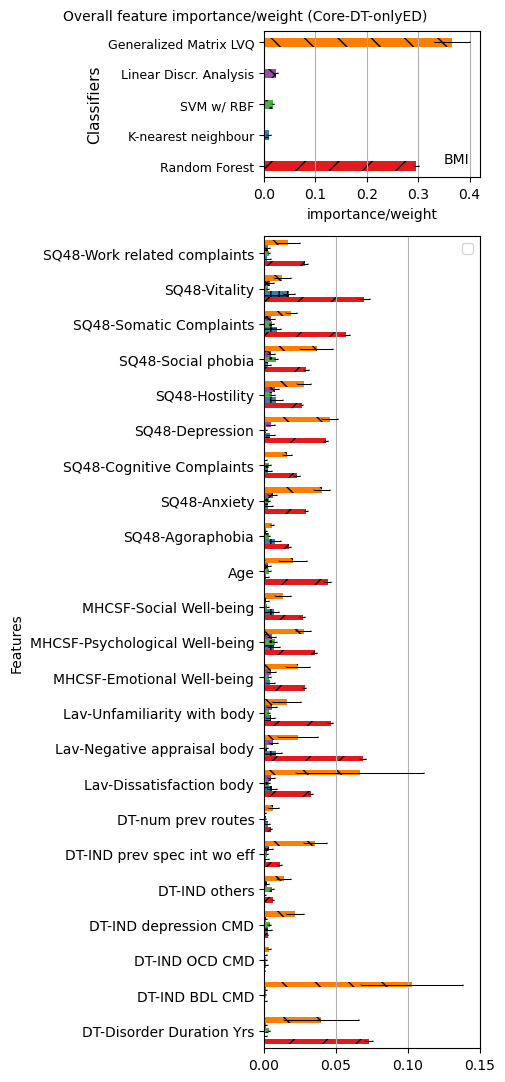

In [13]:
ind2=ind#[1:]
bar_width = 0.15# the width of the bars
shifts=[-0.3,-0.15,0.0,0.15,0.30]#shifts=[-0.4,-0.20,0.0,0.20,0.40]#fig, ax = plt.subplots(1,2, figsize=(9,5))
fig = plt.figure(constrained_layout=True, figsize=(5,11))
widths, ax_all =[0.18,1],[]
spec = fig.add_gridspec(ncols=1, nrows=2, height_ratios=widths)
for colnum in range(2):
    ax_all.append(fig.add_subplot(spec[colnum]))
ax=ax_all[1]
rects_all, bmi_all={},{}
fimp_tabulate={}
for idx,key in enumerate(select_keys1):
    if key in use_permutation_imp:
        bardata, err=np.mean(fimp_all[key]['All'], axis=1), np.std(fimp_all[key]['All'], axis=1)
    else:
        bardata, err=np.mean(fimp_all[key]['All'], axis=0), np.std(fimp_all[key]['All'], axis=0)
    rects_all[key] = ax.barh(ind+shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3), hatch=patterns[idx], color=colors[idx])
    #bmi_all[key]={'mean':bardata[0], 'std':err[0]}
    ax_all[0].barh(idx, bardata[0], xerr=err[0], hatch=patterns[idx], height=bar_width*2, color=colors[idx], error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
    if idx==0:
        ax_all[0].annotate('BMI', xy=(0.35, 0.1))
    mean_err=(np.column_stack((bardata, err))).flatten()
    fimp_tabulate[key]=mean_err
fimp_tabulate=pd.DataFrame.from_dict(data=fimp_tabulate).T
fimp_tabulate.columns=res_df_colname
ax.set_ylabel('Features', fontsize=fs)
ax.set_yticks(ind)
ax.set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs)
ax.legend('')
ax.grid(axis='x')
ax.set_xlim(0,0.15)
ax.set_ylim(-0.5,len(show_col_names)-1.5)
ax_all[0].set_yticks(np.arange(0,len(select_keys1)))
ax_all[0].set_yticklabels(classifier_name1, rotation=0, fontsize=fs-1)
ax_all[0].set_ylabel('Classifiers', fontsize=fs+1)
ax_all[0].set_xlabel('importance/weight', fontsize=fs)
ax_all[0].grid(axis='x')
fig.suptitle('Overall feature importance/weight (%s)'%exp_name, fontsize=fs)
fig.tight_layout()
plt.show()
fig.savefig('figs/PDFs/classification/FIMP1%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,
               pad_inches=0.01)
fig.savefig('figs/PNGs/classification/FIMP1_%s_vert.png'%exp_name, bbox_inches='tight', transparent=True,
               pad_inches=0.01)

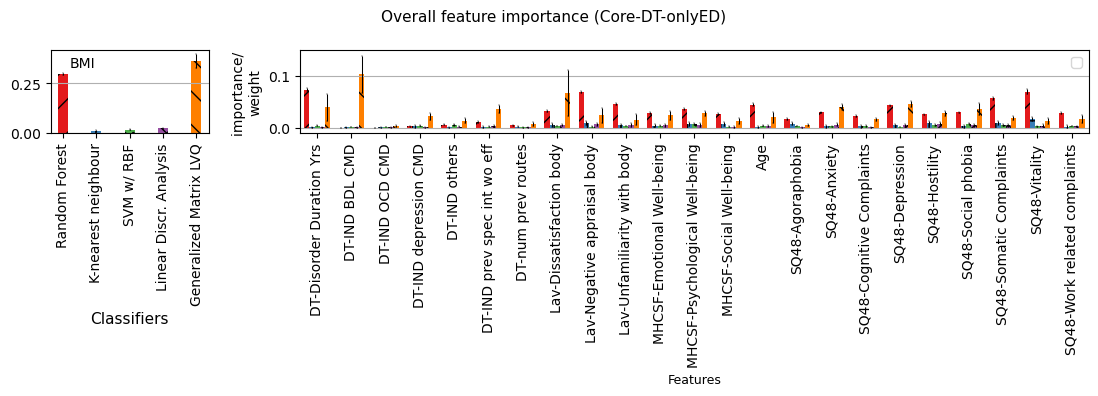

In [14]:
ind2=ind#[1:]
bar_width = 0.15  # the width of the bars
shifts=[-0.3,-0.15,0.0,0.15,0.30]#fig, ax = plt.subplots(1,2, figsize=(9,5))
fig = plt.figure(constrained_layout=True, figsize=(11,5))
widths, ax_all = [0.2,1],[]
spec = fig.add_gridspec(ncols=2, nrows=2, width_ratios=widths)
for colnum in range(2):
    ax_all.append(fig.add_subplot(spec[colnum]))
ax=ax_all[1]
rects_all, bmi_all={},{}
fimp_tabulate={}
for idx,key in enumerate(select_keys1):
    if key in use_permutation_imp:
        bardata, err=np.mean(fimp_all[key]['All'], axis=1), np.std(fimp_all[key]['All'], axis=1)
    else:
        bardata, err=np.mean(fimp_all[key]['All'], axis=0), np.std(fimp_all[key]['All'], axis=0)
    rects_all[key] = ax.bar(ind2 +shifts[idx], bardata[1:], bar_width, yerr=err[1:], label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3), hatch=patterns[idx], color=colors[idx])
    ax_all[0].bar(idx, bardata[0], yerr=err[0], hatch=patterns[idx], color=colors[idx], width=bar_width*2, error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
    if idx==0:
        ax_all[0].annotate('BMI', xy=(0.2, 0.33))
    mean_err=(np.column_stack((bardata, err))).flatten()
    fimp_tabulate[key]=mean_err
fimp_tabulate=pd.DataFrame.from_dict(data=fimp_tabulate).T
fimp_tabulate.columns=res_df_colname
#ax.set_ylabel('Feature weights/ importances', fontsize=fs-3)
ax.set_xlabel('Features', fontsize=fs-1)
ax.set_xticks(ind)
ax.set_xticklabels(show_col_names[1:], rotation=90, fontsize=fs)
ax.legend('')
ax.set_ylabel('importance/ \nweight', fontsize=fs)
ax.grid(axis='y')
ax.set_ylim(-0.01,0.15)
ax.set_xlim(-0.5,len(show_col_names)-1.5)
ax_all[0].set_xticks(np.arange(0,len(select_keys1)))
ax_all[0].set_xticklabels(classifier_name1, rotation=90, fontsize=fs)
ax_all[0].grid(axis='y')
ax_all[0].set_xlabel('Classifiers', fontsize=fs+1)
fig.suptitle('Overall feature importance (%s)'%exp_name, fontsize=fs+1)
fig.tight_layout()
plt.show()
fig.savefig('figs/PDFs/classification/FIMP1%s_horz.pdf'%exp_name, bbox_inches='tight', transparent=False,
               pad_inches=0.01)
fig.savefig('figs/PNGs/classification/FIMP1_%s_horz.png'%exp_name, bbox_inches='tight', transparent=True,
               pad_inches=0.01)

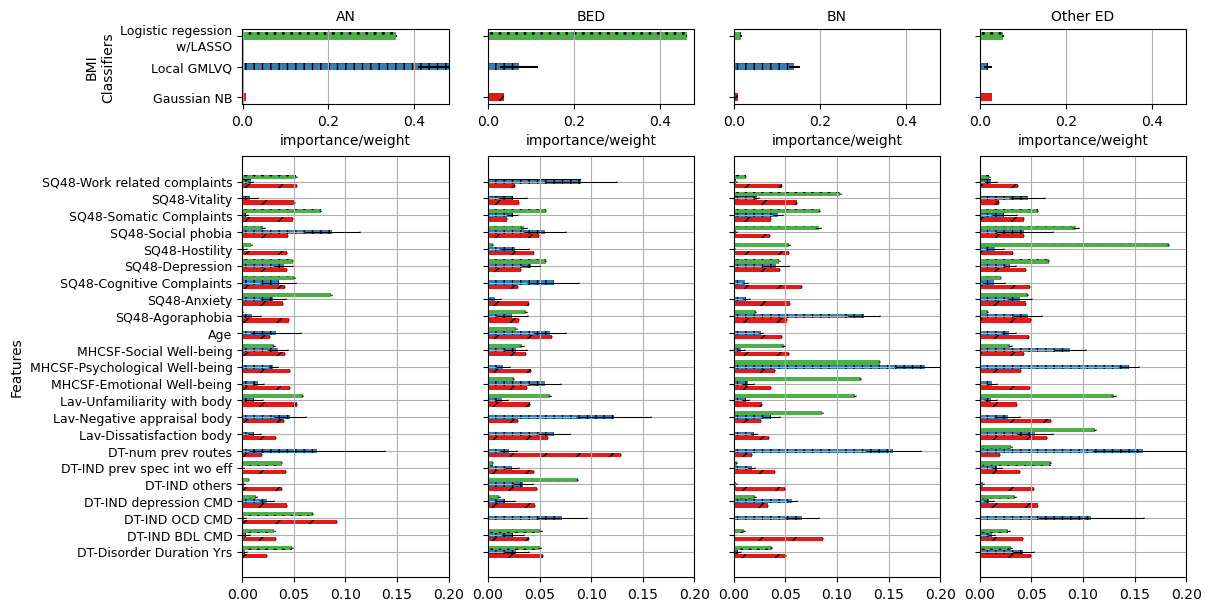

In [21]:
select_keys2=['GNB','LGMLVQ2', 'LogLASSO']
classifier_names=['Gaussian NB','Local GMLVQ', 'Logistic regession\n w/LASSO']
Cls_dict=dict(zip(fimp_all_exps[choice]['GNB']['cls_names'], ['AN','BED','BN', 'Other ED', 'Others']))
bar_width = 0.25  # the width of the bars#shifts=[-0.48, -0.33,-0.167, 0.167,0.33,0.48]
shifts=[-0.25,0.0,0.25]
ind2=ind[1:4]#fig1, ax1 = plt.subplots(nclasses,1, figsize=(8,7), sharex=True)
fig1 = plt.figure(constrained_layout=True, figsize=(12,6))
heights, widths, ax1, ax11 =[0.18,1],np.ones(nclasses),[],[]
spec = fig1.add_gridspec(ncols=nclasses, nrows=2, width_ratios=widths, height_ratios=heights)
for colnum in range(nclasses):
    ax1.append(fig1.add_subplot(spec[1,colnum]))
    ax11.append(fig1.add_subplot(spec[0,colnum]))
rects_all={}
#fimp_all['GNB']['C1']
fimp_tabulate_cw={}
for cls in range(0, nclasses):
    for idx,key in enumerate(select_keys2):
        clsName=fimp_all_exps[choice][key]['cls_names'][cls]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=np.mean(fimp_all[key]['C%d'%(cls+1)]['All'], axis=0), np.std(fimp_all[key]['C%d'%(cls+1)]['All'], axis=0)
        rects_all[key] = ax1[cls].barh(ind +shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key, color=colors[idx],hatch=patterns[idx],
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
        mean_err=(np.column_stack((bardata, err))).flatten()
        fimp_tabulate_cw[key+'-'+Cls_dict[clsName]]=mean_err     
        ax11[cls].barh(idx, bardata[0], height=bar_width, xerr=err[0],  color=colors[idx],hatch=patterns[idx])
# Add some text for labels, title and custom x-axis tick labels, etc.    
    axis_intervals=np.arange(0,0.2,0.05)
    ax1[cls].set_xticks(axis_intervals, minor=True)
    ax1[cls].grid() 
    ax11[cls].grid(axis='x')   
    ax11[cls].set_title('%s'%Cls_dict[clsName], fontsize=fs) 
    ax11[cls].set_xlabel('importance/weight', fontsize=fs)     
    ax1[cls].set_xlim(0,0.2)
    ax11[cls].set_xlim(-0.001,0.48)
    ax1[cls].set_yticks(ind)
    if cls==0:
        ax1[cls].set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs-1)
        ax1[cls].set_ylabel('Features', fontsize=fs)
    else:       
        ax1[cls].set_yticklabels([])
        ax11[cls].set_yticklabels([])
    #if cls==0:
    #    ax1[cls].legend(fontsize=fs-2, loc='upper right', ncol=3)
    #else:
    #    ax1[cls].legend('')
ax11[0].set_yticks(np.arange(0, len(select_keys2)))
ax11[0].set_yticklabels(classifier_names, rotation=0, fontsize=fs-1)
ax11[0].set_ylabel('BMI\nClassifiers', fontsize=fs)
fimp_tabulate_cw=pd.DataFrame.from_dict(data=fimp_tabulate_cw).T
fimp_tabulate_cw.columns=res_df_colname
fig.suptitle(exp_name, fontsize=fs)
fig.tight_layout()
plt.show()
fig1.savefig('figs/PDFs/classification/FIMP2_%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig1.savefig('figs/PNGs/classification/FIMP2_%s_vert.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)

In [22]:
fimp_tabulate_all=pd.concat([fimp_tabulate, fimp_tabulate_cw])
fimp_tabulate_all.to_csv('tabs/Feature_wgt_imp_%s.csv'%exp_name, sep='\t', decimal='.', index=False)

In [23]:
select_keys2, classifier_prot=['GMLVQ','LGMLVQ2'], ['Generalized Matrix LVQ', 'Localized GMLVQ']
fs, nprots=9, np.shape(prots_lvq_all[choice]['GMLVQ']['Mean'])[0]
#prots_per_class=pipeClassifiers_all['GMLVQ'][0]['GMLVQ'].prototype_n_per_class
Cls_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], ['AN','BED','BN', 'OED', 'Others']))
Prot_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], prots_lvq_all[choice]['GMLVQ']['prot_per_cls']))
prot_cls=[]
for clsName, prots in Prot_dict.items():
    for idx in range(prots):
        prot_cls.append('%s-%d'%(Cls_dict[clsName],idx+1))
print(np.shape(prots_lvq_all[2.1]['GMLVQ']['Mean']))
print(Prot_dict)
'prot_per_cls'

(8, 27)
{'Anorexia nervosa': 3, 'Binge-ED': 2, 'Bulimia nervosa': 1, 'Other ED': 1}


'prot_per_cls'

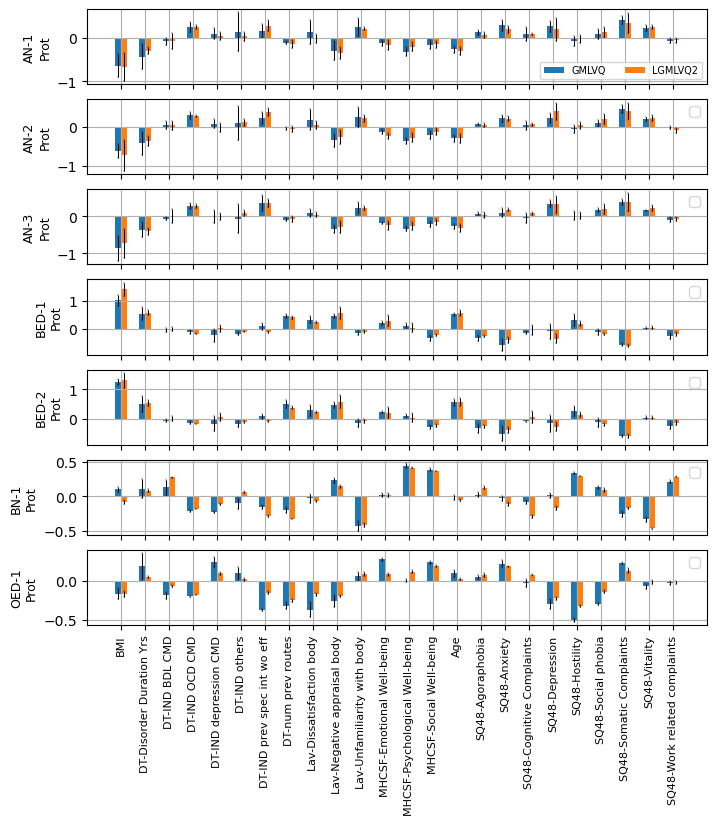

In [24]:
ind, nprots = np.arange(len(adapted_combo_cols)), np.sum(prots_lvq_all[choice]['GMLVQ']['prot_per_cls'])
width = 0.25  # the width of the bars
shifts=[-0.125,0.125]
choice=1.1
fig2, ax2 = plt.subplots(nprots,1, figsize=(8,8), sharex=True)
rects_all={}
norm_profile_all, profile_all={},{}
prof_mean, prof_std=dataset_types[choice]['mean'], dataset_types[choice]['std']
for prot in range(nprots):
    true_scale=np.zeros((np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0], np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[2]))
    for idx,key in enumerate(['GMLVQ','LGMLVQ2']):
        clsName=prot_cls[prot]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=prots_lvq_all[choice][key]['Mean'][prot], prots_lvq_all[choice][key]['Std'][prot]        
        rects_all[key] = ax2[prot].bar(ind +shifts[idx], bardata, width, yerr=err, label=key, 
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
        mean_err=(np.column_stack((bardata, err))).flatten()
        norm_profile_all[key+'-'+clsName]=mean_err
        for iter in range(np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0]):
            true_scale[iter, :]=(prots_lvq_all[choice][key]['All'][iter][prot]*prof_std)+prof_mean       
        profile_all[key+'-'+clsName]=(np.column_stack((np.mean(true_scale, axis=0), np.std(true_scale, axis=0)))).flatten()
# Add some text for labels, title and custom x-axis tick labels, etc.
    ax2[prot].set_ylabel('%s\nProt'%clsName, fontsize=fs)
    ax2[prot].set_xticks(ind)
    ax2[prot].grid()        
    if prot==nprots-1:
        ax2[prot].set_xticklabels(show_col_names, rotation=90, fontsize=fs-1)
    else:       
        ax2[prot].set_xticklabels([])
    if prot==0:
        ax2[prot].legend(fontsize=fs-2, loc='lower right', ncol=2)
    else:
        ax2[prot].legend('')
   # ax2[prot].set_ylim([-1, 1.75])
fig.tight_layout()
plt.show()
profile_all=pd.DataFrame.from_dict(data=profile_all).T
profile_all.columns=res_df_colname
norm_profile_all=pd.DataFrame.from_dict(data=norm_profile_all).T
norm_profile_all.columns=res_df_colname
fig2.savefig('figs/PDFs/classification/Prots_%s.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig2.savefig('figs/PNGs/classification/Prots_%s.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
norm_profile_all.to_csv('tabs/normed_CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=False)
profile_all.to_csv('tabs/CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=False)

In [25]:
Prot_dict

{'Anorexia nervosa': 3, 'Binge-ED': 2, 'Bulimia nervosa': 1, 'Other ED': 1}

(8, 27)
{'Anorexia nervosa': 3, 'Binge-ED': 2, 'Bulimia nervosa': 1, 'Other ED': 1}


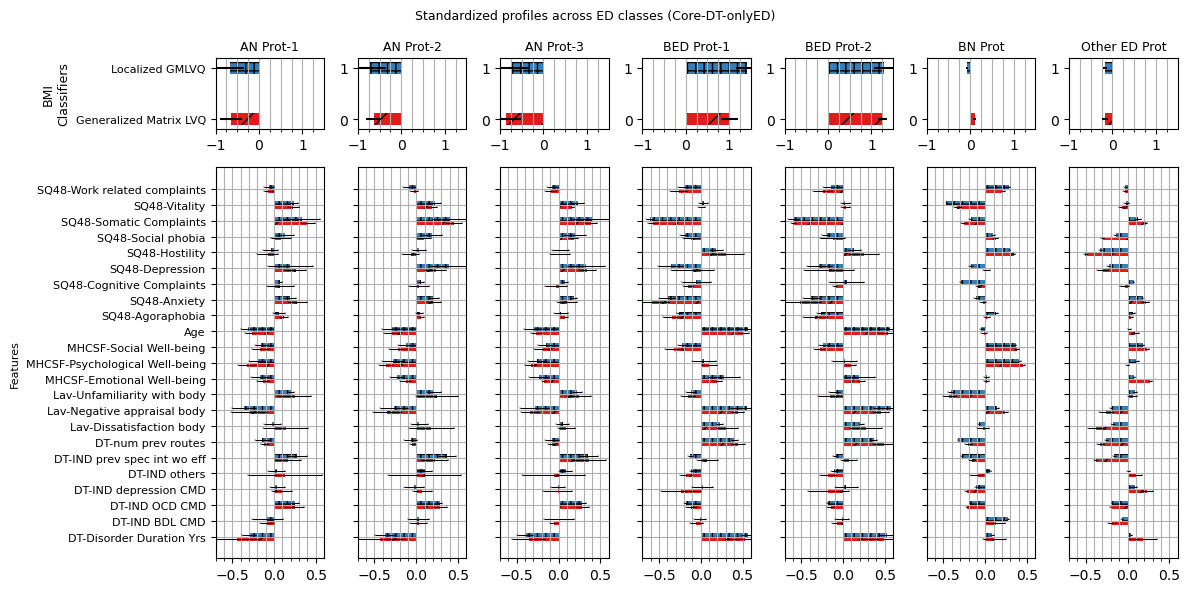

In [27]:
fig3 = plt.figure(constrained_layout=True, figsize=(12,6))
select_keys2, classifier_prot=['GMLVQ','LGMLVQ2'], ['Generalized Matrix LVQ', 'Localized GMLVQ']
fs, nprots=9, np.shape(prots_lvq_all[choice]['GMLVQ']['Mean'])[0]
#prots_per_class=pipeClassifiers_all['GMLVQ'][0]['GMLVQ'].prototype_n_per_class
Cls_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], ['AN','BED','BN', 'Other ED', 'Others']))
Prot_dict=dict(zip(prots_lvq_all[choice]['GMLVQ']['cls_names'], prots_lvq_all[choice]['GMLVQ']['prot_per_cls']))
prot_cls=[]
for clsName, prots in Prot_dict.items():
    for idx in range(prots):
        if Prot_dict[clsName]==1:
            prot_cls.append('%s Prot'%(Cls_dict[clsName]))
        else:
            prot_cls.append('%s Prot-%d'%(Cls_dict[clsName],idx+1))
print(np.shape(prots_lvq_all[2.1]['GMLVQ']['Mean']))
print(Prot_dict)
'prot_per_cls'
heights, widths, ax3, ax31 =[0.18,1],np.ones(nprots),[],[]
spec3 = fig3.add_gridspec(ncols=nprots, nrows=2, width_ratios=widths, height_ratios=heights)
for colnum in range(nprots):
    ax3.append(fig3.add_subplot(spec3[1,colnum]))
    ax31.append(fig3.add_subplot(spec3[0,colnum]))
rects_all={}
norm_profile_all, profile_all={},{}
prof_mean, prof_std=dataset_types[choice]['mean'], dataset_types[choice]['std']
for prot in range(nprots):
    true_scale=np.zeros((np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0], np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[2]))
    for idx,key in enumerate(['GMLVQ','LGMLVQ2']):
        clsName=prot_cls[prot]#pipeClassifiers_all[key][0][key].classes_[cls]
        bardata, err=prots_lvq_all[choice][key]['Mean'][prot], prots_lvq_all[choice][key]['Std'][prot]        
        rects_all[key] = ax3[prot].barh(ind[1:] +shifts[idx], bardata[1:], height=bar_width, xerr=err[1:], label=key, color=colors[idx], hatch=patterns[idx],
                           error_kw=dict(lw=0.75, capsize=0.5, capthick=0.3))
        mean_err=(np.column_stack((bardata, err))).flatten()
        norm_profile_all[key+'-'+clsName]=mean_err
        for iter in range(np.shape(prots_lvq_all[choice]['GMLVQ']['All'])[0]):
            true_scale[iter, :]=(prots_lvq_all[choice][key]['All'][iter][prot]*prof_std)+prof_mean       
        ax31[prot].barh(idx, bardata[0], height=bar_width, xerr=err[0],  color=colors[idx],hatch=patterns[idx])
# Add some text for labels, title and custom x-axis tick labels, etc.    
    minor_ticks, minor_ticks2 = np.arange(-0.7, 0.6, 0.1), np.arange(-1, 1.5, 0.25)
   # ax3.set_xticks(minor_ticks)
    ax3[prot].set_xticks(minor_ticks, minor=True)
    ax3[prot].grid(which='both')    
    #ax31[prot].grid(axis='x')   
    ax31[prot].set_title('%s'%clsName, fontsize=fs)
    ax3[prot].set_xlim(-0.7,0.6)
    ax31[prot].set_xticks(minor_ticks2, minor=True)
    ax31[prot].grid(axis='x', which='both')  
    ax31[prot].set_xlim(-1,1.5)
    ax3[prot].set_yticks(ind[1:])
    if prot==0:        
        ax3[prot].set_yticklabels(show_col_names[1:], rotation=0, fontsize=fs-1)
        ax3[prot].set_ylabel('Features', fontsize=fs-1)
    else:       
        ax3[prot].set_yticklabels([])
ax31[0].set_yticks(np.arange(0, len(select_keys2)))
ax31[0].set_yticklabels(classifier_prot, rotation=0, fontsize=fs-1)
ax31[0].set_ylabel('BMI\nClassifiers', fontsize=fs)
fig3.suptitle('Standardized profiles across ED classes (%s)'%exp_name, fontsize=fs)
fig3.tight_layout()
#plt.show()
fig2.savefig('figs/PDFs/classification/Prots_%s_vert.pdf'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
fig2.savefig('figs/PNGs/classification/Prots_%s_vert.png'%exp_name, bbox_inches='tight', transparent=False,\
               pad_inches=0.01)
#norm_profile_all.to_csv('tabs/normed_CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=False)
#profile_all.to_csv('tabs/CW_Profiles_%s.csv'%exp_name, sep='\t', decimal='.', index=False)

## Only ED classes

# Regression
### In regression, the closer the R2 score is to 1 the better is the model's performance, and the closer RMSE is to 0, the better is teh performance

In [7]:
choice_regs=[1.0,3.0]
savepicklpath='%s/pickles/'%(os.getcwd())
for keyD, val in choice_dict.items():
    if keyD in choice_regs:    
        dataset_type=save_dict[keyD]#'Core_DT'#save_dict[choice]
        model_fname='%s_reg2.pkl'%dataset_type
        modelsRegress='%s%s'%(savepicklpath, model_fname)          
        Ytrain, Ytest=dataset_types[keyD]['Ytrain_reg'], dataset_types[keyD]['Ytest_reg']               
        if keyD>=3: 
            Xtrain, Xtest=dataset_types[keyD]['zXtrain'], dataset_types[keyD]['zXtest']
        else:
            Xtrain, Xtest=dataset_types[keyD]['mice_zXtrain'], dataset_types[keyD]['mice_zXtest']
        if os.path.exists(modelsRegress):
            print('Pickled files found')#pickle.load(open('%s'%modelsClassify_permut, "rb"))
            regressor_all=pickle.load(open('%s'%modelsRegress, "rb"))
            for keyReg in regressor_all.keys():            
                perf_dict=regressor_all[keyReg]['Performance']
                for split in ['Training', 'Test']:
                    print('Exp-%d%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(keyD, keyReg, split,
                                    perf_dict[keyReg+split]['R2(mean)'], perf_dict[keyReg+split]['R2(std)'],
                                    perf_dict[keyReg+split]['RMSE(mean)'], perf_dict[keyReg+split]['RMSE(std)']))


Pickled files found
Exp-1RF Training: R2= 0.800 (0.001), RMSE= 0.560 (0.001)
Exp-1RF Test: R2= 0.659 (0.004), RMSE= 0.826 (0.004)
Exp-1KNN Training: R2= 0.751 (0.000), RMSE= 0.625 (0.000)
Exp-1KNN Test: R2= 0.452 (0.000), RMSE= 1.047 (0.000)
Exp-1LSVC Training: R2= 0.614 (0.000), RMSE= 0.778 (0.000)
Exp-1LSVC Test: R2= 0.495 (0.000), RMSE= 1.005 (0.000)
Exp-1RSVC Training: R2= 0.686 (0.000), RMSE= 0.702 (0.000)
Exp-1RSVC Test: R2= 0.522 (0.000), RMSE= 0.978 (0.000)
Exp-1LASSOReg Training: R2= 0.593 (0.000), RMSE= 0.800 (0.000)
Exp-1LASSOReg Test: R2= 0.634 (0.000), RMSE= 0.856 (0.000)
Pickled files found
Exp-3RF Training: R2= 0.804 (0.001), RMSE= 0.536 (0.002)
Exp-3RF Test: R2= 0.628 (0.001), RMSE= 0.820 (0.001)
Exp-3KNN Training: R2= 0.726 (0.000), RMSE= 0.634 (0.000)
Exp-3KNN Test: R2= 0.369 (0.000), RMSE= 1.068 (0.000)
Exp-3LSVC Training: R2= 0.584 (0.000), RMSE= 0.781 (0.000)
Exp-3LSVC Test: R2= 0.606 (0.000), RMSE= 0.844 (0.000)
Exp-3RSVC Training: R2= 0.634 (0.000), RMSE= 0.733 (

## Regression (all classes)

In [17]:
num_features, iters=df_train_eds.shape[1],5
all_relevance=np.zeros((nclasses2, num_features, iters))
perf_dict, regressor_all, train_perf_all, test_perf_all={},{},{},{}
for key, reg in pipeRegressors.items():
    tr_perf=np.zeros((2, iters))
    te_perf=np.zeros((2, iters))
    reg_all=[]
    for iter in range(iters):
        reg.fit(z_train_explore, YTrain_reg)
        reg_all.append(reg)
        train_pred_labs_eds=reg.predict(z_train_explore)
        test_pred_labs_eds=reg.predict(z_test_explore)
        tr_perf[0,iter]=r2_score(YTrain_reg, train_pred_labs_eds)
        te_perf[0,iter]=r2_score(YTest_reg, test_pred_labs_eds)
        tr_perf[1,iter]=root_mean_squared_error(YTrain_reg, train_pred_labs_eds)
        te_perf[1,iter]=root_mean_squared_error(YTest_reg, test_pred_labs_eds)
    regressor_all[key]=reg_all
    train_perf_all[key], test_perf_all[key]=tr_perf, te_perf
    perf_dict[key+'Training']={'R2(mean)': np.mean(tr_perf[0,:]),'R2(std)': np.std(tr_perf[0,:]),
                    'RMSE(mean)': np.mean(tr_perf[1,:]),'RMSE(std)': np.std(tr_perf[1,:])}
    perf_dict[key+'Test']={'R2(mean)': np.mean(te_perf[0,:]),'R2(std)': np.std(te_perf[0,:]),
                          'RMSE(mean)': np.mean(te_perf[1,:]),'RMSE(std)': np.std(te_perf[1,:])}
    for split in ['Training', 'Test']:
        print('%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(key, split,
                    perf_dict[key+split]['R2(mean)'], perf_dict[key+split]['R2(std)'],
                    perf_dict[key+split]['RMSE(mean)'], perf_dict[key+split]['RMSE(std)']))
#print(perf_dict)

RF Training: R2= 0.756 (0.004), RMSE= 0.589 (0.005)
RF Test: R2= 0.461 (0.029), RMSE= 0.861 (0.023)
KNN Training: R2= 0.582 (0.000), RMSE= 0.770 (0.000)
KNN Test: R2= 0.261 (0.000), RMSE= 1.008 (0.000)
LSVC Training: R2= 0.490 (0.000), RMSE= 0.850 (0.000)
LSVC Test: R2= 0.358 (0.000), RMSE= 0.939 (0.000)
RSVC Training: R2= 0.566 (0.000), RMSE= 0.785 (0.000)
RSVC Test: R2= 0.408 (0.000), RMSE= 0.902 (0.000)
LASSOReg Training: R2= 0.542 (0.000), RMSE= 0.806 (0.000)
LASSOReg Test: R2= 0.504 (0.000), RMSE= 0.826 (0.000)


In regression there does not seem to be relevant performance boost by exclusion of the non-ED class patients